## 📡 Investigation of Spatial Signal Properties in MIMO Systems

This homework assignment introduces fundamental concepts of **spatial signal processing in MIMO communication systems**.  
During this work, you will develop a simplified (toy) MIMO simulator and investigate the influence of channel precoding on system performance.

---
#### 🎯 Learning Objectives
By completing this assignment, you will:

1. Analyze the spatial characteristics of MIMO wireless channels.
2. Study spatial filtering techniques based on precoding methods (e.g., SVD-based and uniform precoders).
3. Explore methods for visualizing spatial spectra.
4. Evaluate the impact of channel estimation errors on MIMO system performance.

---
#### 📁 Working Environment

For this assignment, you will use **pre-generated channel realizations** provided by course instructors. [Link to Google drive](https://drive.google.com/drive/folders/1tUclwrA14O5d8feUSFjY62COIv7sDQBH?usp=share_link).

You may choose one of the following working modes:

1. **Local Execution**  
   Download the provided MATLAB `.mat` files and this Jupyter notebook, and run all experiments on your local machine.

2. **Cloud-Based Execution (Google Colab)**  
   Use Google Colab, mount your Google Drive containing the channel files, and perform the experiments in the cloud.

> Ensure that all required channel files are correctly placed in the working directory before running the notebook. 
> Use any channel 1, 2, 3 for the main tasks. For tasks where it's required to compare results for different channels use PATH and SPEED channels.

#### 🛠️ Software Tools and Channel Data Description

In this assignment, we use the **NumPy** and **SciPy** libraries to implement signal processing algorithms and to gain practical insight into the physical layer of MIMO communication systems.

In addition, one external library is required for OFDM signal generation and processing. This library provides basic modulation and demodulation functionalities.

You may install it using:

```bash
!pip install -q ModulationPy
 

#### ⚠️ Computational Efficiency: Avoid Explicit Loops

> Excessive use of Python loops in this homework may significantly increase the runtime of your simulations, potentially extending execution time to several hours.
>
> You are strongly encouraged to use **vectorized and stacked operations** in NumPy, which rely on optimized BLAS libraries and provide substantial performance improvements.
>
> If you experience difficulties with vectorized implementations, you may temporarily use loop-based solutions and consult the course instructor for assistance with code optimization.


In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem
from tqdm.notebook import tqdm, trange
from numpy import sqrt
plt.rcParams.update({'font.size': 15})

USE_GOOGLE_DRIVE = False
FOLDER_PATH = '/' #  <<< Set your value here

# Which channel file you'd like to load
CHAN_NAME = 'link_chan_{}.mat'.format('2') #  <<< Set your value here

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/gdrive')
    CHAN_NAME = 'link_chan_{}.mat'.format('2')

os.chdir(FOLDER_PATH)

###  📕Channel structure
Let us load one of the `.mat` channel files and examine its structure. 

The measured MIMO channel is represented as a complex-valued, high-dimentional tensor:
$$\mathcal{H} \in \mathbb{C}^{M \times N \times K \times T},$$
where:
- $M - $Number of antennas at the user equipment (UE) side (4),
- $N - $Number of antennas at the base station (BS) side (64),
- $K - $Number of OFDM subcarriers used for data transmission (600),
- $T - $Number of time instants at which the channel was measured (100).
This is common MIMO channel representation.

As an initial step, we consider a simple (although limited in interpretability) visualization of the channel by plotting the frequency-domain amplitudes and phases between a fixed transmit-receive antenna pair $(m,n)$ at a selected time instant $t$.

Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  600
Number of time moments:  100


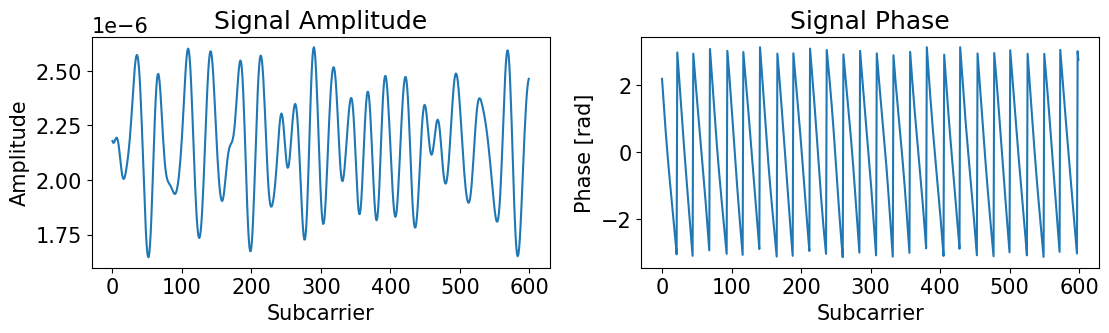

In [3]:
H = scipy.io.loadmat(FOLDER_PATH+CHAN_NAME)['Link_Channel']
H = H.transpose(3,2,0,1)

N_tti, N_subcarriers, N_ue_ants, N_bs_ants = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

# Fixing antenna pair and time instant
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
plt.plot(np.abs(H[0,:,0,0]))
plt.title('Signal Amplitude'); plt.xlabel('Subcarrier'); plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(np.angle(H[0,:,0,0]))
plt.title('Signal Phase'); plt.xlabel('Subcarrier'); plt.ylabel('Phase [rad]')
plt.show()

## 📶 Influence of Precoding in MIMO AWGN Channels

From the lectures, you are familiar with various **precoding techniques**, which are signal processing methods used in antenna arrays to enable directional signal transmission and reception.

In this section, we investigate the performance gains achieved by precoding when transmitting signals over channels affected by **additive white Gaussian noise (AWGN)**.

To this end, we construct a simplified MIMO system simulator and analyze signal transmission under different noise conditions, characterized by varying **signal-to-noise ratios (SNRs)**.


### Signal-to-Noise Ratio and Noise Modeling
From the lectures, recall that the **signal-to-noise ratio (SNR)** is defined as the ratio between the received signal power  $P_s$ and the noise power $P_n$:
$$
\mathrm{SNR} = \frac{P_s}{P_n}.
$$
In practical communication systems, the dominant contribution to additive white Gaussian noise (AWGN) originates from [thermal noise](https://en.wikipedia.org/wiki/Johnson–Nyquist_noise), whose power primarily depends on the receiver temperature and system bandwidth. As a result, the noise power can be considered approximately constant over time.

In contrast, due to multipath propagation and channel fading, the received signal power varies across time, frequency, and spatial dimensions. So, the instantaneous SNR is generally time-varying.

📍In this assignment, we investigate the impact of precoding under **fixed average SNR conditions**. For this purpose, we control the noise variance such that the average SNR per antenna pair and per subcarrier is kept constant.


In [4]:
def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array with shape of (100, 600, 4, 64)
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    
    # Calculate mean signal power
    P_signal = np.mean(np.abs(signal)**2, axis = (-1,-2,-3), keepdims = True)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed

### Channel Normalization and Automatic Gain Control
Another important aspect of AWGN channel modeling is *channel normalization*. In practical receivers, most of the noise is introduced after signal reception. To ensure proper quantization and prevent saturation *automatic gain control (AGC)* unit is typically employed  to normalize the received signal power. 
In this work, we assume that the received signal is normalized such that each receive antenna has unit average power.
Specifically, for each received channel slice $\mathbf{H}_{rx}\in \mathbb{C}^{M \times K}$, we enforce the normalisation condition

$$\| H_{rx} \|^2_F = \sum_{m=1}^{M}\sum_{k=1}^{K} |H(m,k)|^2 = M,$$

where:
- $H_{rx}$  denotes the received channel matrix for a fixed base station antenna and transmission time interval (TTI),
- $\| \cdot \|_F$ denotes Frobenius norm,

This normalization ensures consistent power scaling across different channel realizations and enables fair performance comparisons under varying SNR conditions.


In [5]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    Inputs: 
        - H: (np.ndarray) the channel array with shape (100, 600, 4, 64)
    Outputs:
        -H_normed (np.ndarray) the channel array with shape (100, 600, 4, 64)
    '''
    N_ue = H.shape[-2]
    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (-2,-3), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed

Now we implement a step-by-step simulation of MIMO data transmission and reception.

### Bit generation

We begin by generating a binary information sequence to be transmitted. In Python, a random bit sequence can be created as follows:


In [6]:
bits = np.random.binomial(n = 1, p = 0.5, size = N_subcarriers)
print(bits[:30])

[1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1]


However, in practical communication systems, it is often desirable to transmit multiple bits per symbol. Moreover, the information must be converted from its digital (binary) representation into a physical waveform representation. This process is known as **digital modulation**.

For signal modulation and demodulation, we use the *ModulationPy* library. Alternatively, you may use or get acquainted with modulation schemes [implementation](https://www.nrexplained.com/modulation)

In this assignment, we consider the following modulation formats BPSK, QPSK, 16-QAM, and other higher-order $ M $-QAM schemes.

Below is an example illustrating the use of a digital modulator.

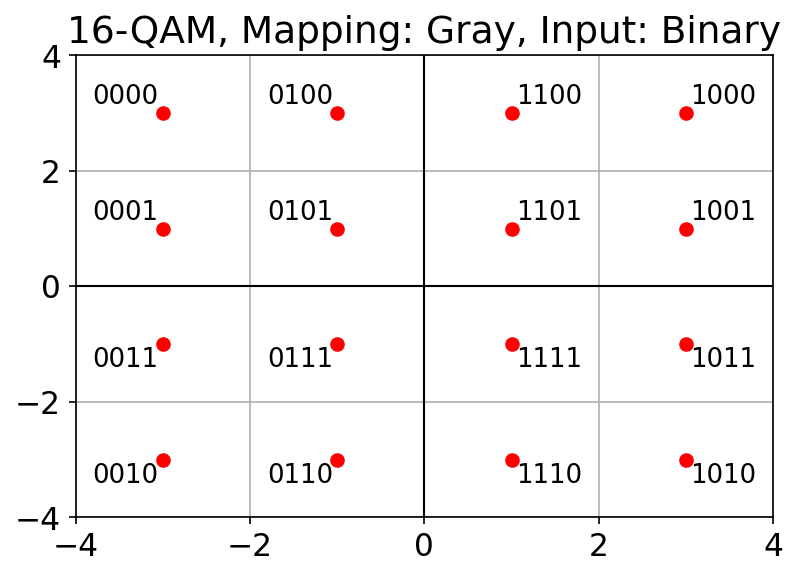

In [7]:
N_constellation_points = 16 # 16QAM modulation

# How many bits we can send using defined number of constellation points
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
                 bin_input = True,              # it will use bits as input
                 gray_map = True,               # reorder constellation points to have unit distance between neighbours
                 soft_decision = False,         # hard detector for detection
                 bin_output = True)             # demodulate signal to bits
modem.plot_const()


In addition, the constellation points are normalized to ensure unit average symbol energy, that is,

$$
\mathbb{E}\left(|s|^2\right) = 1.
$$

This normalization guarantees consistent power scaling and enables fair performance comparisons across different modulation schemes.


In [8]:
# For each subcarrier transform N_bits_per_conts_point bits into one QAM symbol
bits = np.random.binomial(n = 1, p = 0.5, size = (N_subcarriers * N_bits_per_conts_point))

# Normalization constant. Dont forget to denormalize signal before decoding!
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# Create 1 OFDM symbol with N_subcarriers QAM symbols.
qam_symbols = modem.modulate(bits) / constellation_norm

# Print some symbols and check the normalization
print('S size: ',qam_symbols.shape, end = '\n\n')
print('Some symbols : ',qam_symbols[:15], end = '\n\n')
print('Expectation is', np.mean(np.abs(qam_symbols)**2))

S size:  (600,)

Some symbols :  [-0.31622777+0.31622777j -0.31622777-0.31622777j  0.9486833 -0.31622777j
 -0.9486833 +0.31622777j -0.31622777-0.31622777j -0.9486833 +0.9486833j
  0.9486833 +0.9486833j   0.31622777-0.31622777j -0.31622777+0.31622777j
  0.31622777-0.9486833j  -0.9486833 +0.9486833j   0.31622777-0.9486833j
 -0.31622777-0.31622777j -0.9486833 -0.31622777j  0.31622777-0.9486833j ]

Expectation is 1.0306666666666666


### 📕 Precoding

In order to transmit the modulated symbols using $N$ transmit antennas, the data stream must be mapped onto the antenna array through a **precoding** operation.

We begin with a simple **uniform precoder**, which is already implemented in the provided code. This precoder distributes the same symbol equally across all transmit antennas:

$$
\underset{N \times 1}{\mathbf{P}(k,t)} = \sqrt{\frac{1}{N}}
\begin{bmatrix}
1 \\
\dots \\
1 \\
\end{bmatrix}
$$

This scheme serves as a baseline solution, since it does not exploit the spatial characteristics of the MIMO channel. The same signal is transmitted by all antennas with equal power, and the total transmit power is evenly distributed among them.

---

### 📍SVD-Based Precoding

Next, we implement a **singular value decomposition (SVD)–based precoder**, which exploits channel state information.

For each subcarrier $k$ and time instant $t$, the estimated channel matrix can be factorized as

$$
\underset{M \times N}{\mathbf{H}(k,t)} = \underset{M \times M}{\mathbf{U}(k,t)} \underset{M \times N}{\mathbf{\Sigma}(k,t)} \underset{N \times N}{\mathbf{V}^H(k,t)}
$$

where:

- $ \mathbf{U}(k,t) \in \mathbb{C}^{M \times M} $ contains left singular vectors,
- $ \mathbf{\Sigma}(k,t) \in \mathbb{R}^{M \times N} $ is a diagonal matrix of singular values,
- $ \mathbf{V}(k,t) \in \mathbb{C}^{N \times N} $ contains right singular vectors,
- $ (\cdot)^H $ denotes the Hermitian transpose.

The columns of $ \mathbf{V} $ correspond to orthonormal transmit directions ordered according to decreasing singular values:

$$
\mathbf{V} = \left[ \mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_N \right],
$$
Where each $\mathbf{v}_1 \in \mathbb{C}^{N \times 1}$ are singular vectors that that can be used as a precoder. 

#### 📌 Single-stream transmission
For **single-stream transmission**, the precoding vector is selected as the right singular vector associated with the largest singular value:

$$
\mathbf{p}_{\mathrm{SVD}}(k,t)
=
\mathbf{v}_1(k,t).
$$

This choice maximizes the received signal power and provides the optimal beamforming direction under perfect channel state information.

#### 📌 Multi-stream transmission 
For **multi-stream transmission**, the precoder is formed using the first $L$ right singular vectors:

$$
\mathbf{P}_{\mathrm{SVD}}
=
\left[
\mathbf{v}_1,\,
\mathbf{v}_2,\,
\ldots,\,
\mathbf{v}_L
\right]
\in \mathbb{C}^{N \times L},
$$

where $L$ denotes the number of transmitted data streams.

This approach enables spatial multiplexing by transmitting multiple independent data streams over orthogonal spatial channels.

#### ⚖️ Power normalisation
When using multi-stream precoding, it is necessary to ensure that the total transmit power remains constant.

Therefore, the precoding matrix is normalized such that its Frobenius norm satisfies

$$
\| \mathbf{P}_{\mathrm{SVD}} \|_F^2 = 1.
$$

This normalization guarantees that the total transmitted power is independent of the number of spatial streams.

Using multi-stream scheme you need to be sure that Frobenius norm of the precoder $\mathbf{P}\in\mathbb{C}^{N \times L}$ is equal to 1, which means that precoder keeps the same transmiting power.  


### 🔴 Questions and tasks:
1. Why is it not possible to reliably transmit multiple independent data streams using the uniform precoder, in contrast to SVD-based precoding?

2. What is the optimal strategy for normalizing SVD precoding vectors in single-stream and multi-stream transmission scenarios?

3. How to define a maximum possible streams that can be reliably transmitted?


### ✅ Answers: 
Write here

In [10]:
def get_precoder(H, rank, precoder_type = 'uniform'):
    '''
    :param H: (np.ndarray) the channel array
    :param rank: (int) the rank of the precoder
    :param precoder_type: (str) the type of precoder. 'svd' of 'uniform'
    :return: (np.ndarray) precoder
    '''
    
    H_shape = H.shape
    
    if precoder_type == 'svd':
        # Here is your code ...
        raise NotImplementedError('SVD precoder is not implemented yet.')
        
    elif precoder_type == 'uniform':
        assert rank == 1  # impossible to use other ranks
        precoder = np.ones((*H_shape[:-2], H_shape[-1], rank)) / (np.sqrt(64 * rank))
        return precoder

In [11]:

# Precoder testing for fixed time moment
t = 0
Ht = H[t]

# Calculate precoder
precoder = get_precoder(H = Ht, rank = 1, precoder_type = 'uniform')

print('precoder shape: ', precoder.shape)
print('precoder power per subcarrier: ', np.sum(np.abs(precoder)**2)/N_subcarriers)

precoder shape:  (600, 64, 1)
precoder power per subcarrier:  1.0


### 📍 Transmitted Signal Formation
After selecting the precoding matrix, we construct the precoded transmitted signal.

For each subcarrier $k$ and time instant $t$, the transmitted signal is given by

$$
\underset{N \times 1}{\mathbf{x}(k,t)}
=
\underset{N \times L}{\mathbf{P}(k,t)}
\;
\underset{L \times 1}{\mathbf{s}(k,t)},
$$

where:

- $ \mathbf{P}(k,t) $ is the precoding matrix,
- $ \mathbf{s}(k,t) $ is the vector of modulated symbols,
- $ L $ is the number of transmitted data streams (denoted as `rank` in the implementation),
- $ \mathbf{x}(k,t) $ is the transmitted signal vector across $ N $ antennas.

This operation maps $L$ independent data streams onto the transmit antenna array.



In [12]:
def transmitter_signal(s_signal, precoder):
    # Your code here
    raise NotImplementedError('Transmitter is not implemented yet.')

# print information about TX signal
X = transmitter_signal(s_signal = qam_symbols[:,None, None], precoder = precoder)
print('TX signal shape:', X.shape)
print('TX signal power: ', np.sum(np.abs(X)**2))

TX signal shape: (600, 64, 1)
TX signal power:  618.4000000000001


### 📍Received Signal Model

Next, we model the received signal on each subcarrier as the product of the channel matrix and the transmitted signal vector, corrupted by additive noise.

The received signal model is given by

$$
\underset{M \times 1}{\mathbf{y}(k,t)}
=
\underset{M \times N}{\mathbf{H}(k,t)}
\;
\underset{N \times 1}{\mathbf{x}(k,t)}
+
\underset{M \times 1}{\mathbf{n}(k,t)},
$$

where:

- $ \mathbf{H}(k,t) $ is the MIMO channel matrix,
- $ \mathbf{x}(k,t) $ is the transmitted signal vector,
- $ \mathbf{n}(k,t) $ is the complex AWGN vector,
- $ \mathbf{y}(k,t) $ is the received signal vector,
- $ M $ is the number of receive antennas.

This equation represents the standard baseband discrete-time MIMO channel model.


In [13]:
def receiver_signal(H, X, SNR_dB):
    noise = get_noise(np.mean(H, -1, keepdims=True) * sqrt(64), SNR_dB)
    return H @ X + noise 

# Check received signal and SNR
# define SNR value
SNR = -10

# Obtain ideal signal without noise
Y_ideal = receiver_signal(Ht, X, None)

# Obtain signal with noise
Y_noisy = receiver_signal(Ht, X, SNR)

# Get noise tensor
Noise = Y_noisy - Y_ideal

# Calcualte mean ideal signal Power
Signal_power_dB = 10 * np.log10( np.mean( np.abs(Y_ideal)**2 ))

# Calculate mean noise Power
Noise_power_dB = 10 * np.log10( np.mean( np.abs(Noise)**2 ))

# Check SNR value
print('SNR: ', Signal_power_dB - Noise_power_dB, 'dB')


SNR:  -9.862674535735806 dB


The final objective of the receiver is to recover the transmitted bit sequence from the received signal $ \mathbf{y}(k,t) $.

To achieve this, the receiver must estimate the channel through which the signal has propagated. In practical systems, this is typically accomplished by transmitting known pilot symbols and performing channel estimation at the receiver.

Channel estimation and pilot-based training procedures will be studied in subsequent assignments.

In this work, for simplicity, we assume **perfect channel state information (CSI)** at the receiver. More precisely, we assume perfect knowledge of the **effective channel**, defined as

$$
\mathbf{H}_{\mathrm{eff}}(k,t)
=
\mathbf{H}(k,t)\mathbf{P}(k,t).
$$

This assumption allows us to focus on the fundamental properties of precoding and spatial signal processing without introducing additional estimation errors.


In [14]:
def effective_channel(H, P):
    # Your code here
    raise NotImplementedError('Effective channel is not implemented yet.')

H_eff_est = effective_channel(Ht, precoder)
print(H_eff_est.shape)

(600, 4, 1)


### 📍 Signal Equalization and Detection

After estimating the channel, we proceed to recover the transmitted signal at the receiver.

This is achieved using an **equalizer**, which compensates for the channel distortions. In the simplest case, the equalizer is constructed using the Moore–Penrose pseudo-inverse of the effective channel matrix.

More advanced equalization techniques (e.g., Zero-Forcing, MMSE) will be studied in subsequent assignments.


In [15]:
def equalize(Y, H_Est):
    W_equalizer = np.linalg.pinv(H_Est)
    s_est = W_equalizer @ Y
    return s_est

# estimated signal with noise
S_est = equalize(Y_noisy, H_eff_est)

# estimated signal with ideal channel
S_est_ideal = equalize(Y_ideal, H_eff_est)

# print sizes
print(S_est.shape)

(600, 1, 1)


### 📍Demodulation

After equalization, the estimated complex-valued symbols are demodulated back into a binary bit sequence using the corresponding demodulator.

This step completes the digital receiver processing chain.

As the performance metric, we employ the **bit error rate (BER)**, which represents the probability that a transmitted bit is incorrectly detected at the receiver.

In [16]:
def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''
    return np.abs(received_bits - true_bits)

# estimated bit sequence observed with noise
est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)

# estimated bit sequence observed without noise
est_bits_ideal = modem.demodulate(S_est_ideal.flatten() * constellation_norm)

# checking bit-error-rate for noisy channel
print('BER (noisy channel): ', bit_error_rate(bits, est_bits).mean())

# checking bit-error-rate for ideal channel (Must be 0)
print('BER (ideal channel): ', bit_error_rate(bits, est_bits_ideal).mean())

BER (noisy channel):  0.3754166666666667
BER (ideal channel):  0.0


### 📍 Performance Evaluation

Under the assumption of perfect channel state information, the receiver is able to recover the transmitted symbols without errors at sufficiently high SNR values. In this ideal case, the resulting bit error rate (BER) approaches zero.

By combining all implemented processing blocks, we can now evaluate system performance and plot the BER as a function of the SNR level.


In [18]:
H = normalize(H)

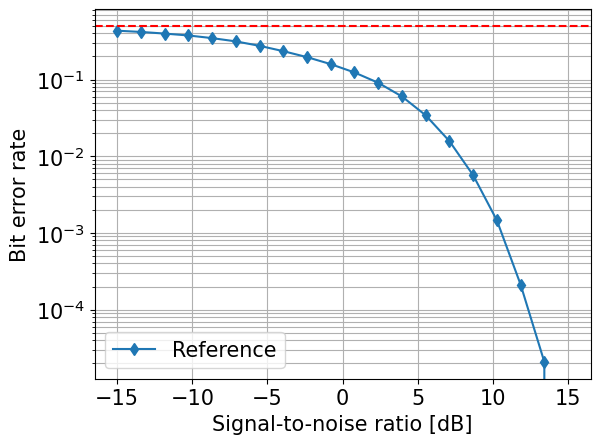

In [19]:
# Write your simulation code here
# Obtained result on your data may differ

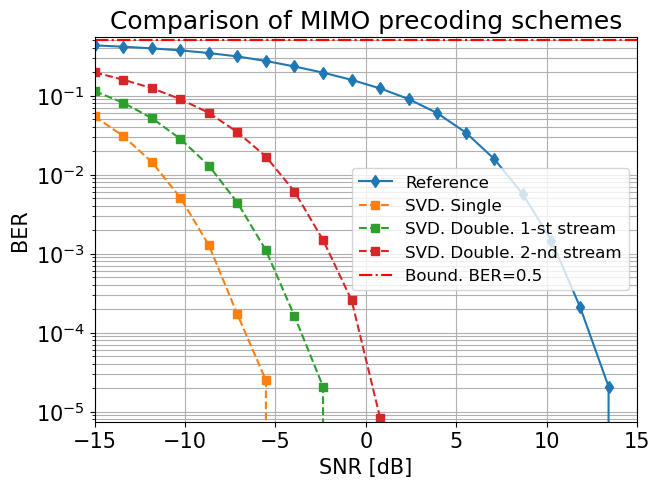

In [22]:
# Write your simulation code here
# Obtained result on your data may differ

### 🔴 Assignment Tasks
1. Calculate $M$ singular values for channel matrices $\mathbf{H}\in \mathbb{C}^{M \times N}$. Average them for all subcarriers $k$ and time instants $t$. 
    Compare resulting singular values for different `.mat` files. Explain what is the difference between channels?   

2. Implement a spatial matched filter based on SVD precoding.

   Plot the resulting BER curve together with the reference baseline curve.

   From the graph, determine the horizontal SNR offset at recommended BER levels (e.g., $10^{-1}$ and $10^{-2}$).

3. Repeat Task 1 using two spatial data streams.

   Analyze the results and provide a reasoned conclusion regarding the effectiveness and suitability of single-stream versus dual-stream transmission for the given channel realization.

   **Note:** Ensure that the total transmit power is properly divided between the two streams in order to enable a fair comparison between one-stream and two-stream transmission schemes.

## 📗 Introduction to Spatial Signal Processing

In MIMO systems, signals arriving at the receiver from different directions propagate over distinct physical paths before reaching individual antenna elements. As a result, the propagation distance from a given source to each antenna element is generally different.

These path length differences lead to deterministic phase shifts across the antenna array, which depend on the direction of arrival of the incident wavefront. For narrowband signals and uniform antenna geometries, this phase variation can be modeled as a spatially periodic structure across antenna elements.

This spatial phase progression can be interpreted as a **spatial frequency**, analogous to temporal frequency in time-domain signal processing. Both domains are connected through the Fourier transform.

Consequently, spatial signal analysis can be performed using discrete Fourier transform (DFT)–based methods, in a manner similar to classical time–frequency analysis.

In this assignment, you are encouraged to explicitly construct DFT steering vectors rather than relying on built-in FFT routines, in order to better understand the underlying signal structure.

---

### 📍 Oversampled Spatial DFT Vectors

An oversampled DFT vector of length $ X $ with normalized spatial frequency $ u \in \big(-\frac{1}{2}, \frac{1}{2}\big] $ is defined as

$$
\mathbf{f}_X(u)
=
\frac{1}{\sqrt{X}}
\exp\left(-j2\pi u \mathbf{x}\right),
\qquad
\mathbf{x} = [0,1,\ldots,X-1]^T.
$$

These vectors represent steering responses of a uniform linear array for different spatial frequencies.

---

### 📍 Antenna Array Structure

The base station antenna array has the following structure:

- $ I = 2 $ polarizations,
- $ P = 4 $ vertical elements,
- $ Q = 8 $ horizontal elements.

Thus, the total number of antennas is

$$
N = I \cdot P \cdot Q.
$$

For spatial analysis, the antenna dimension is reshaped into a three-dimensional tensor of size $ I \times P \times Q $.

<img src="assets/bs_antenna_array.png" width="500">

> ⚠️ **Important:** The ordering of indices in the reshape operation must be consistent with the original antenna layout. An incorrect ordering leads to distorted spatial spectra.

---

### 📍 Spatial Spectrum Estimation

Fix a time instant $ t $, a subcarrier $ k $, and a user antenna index $ m $.

After reshaping, the corresponding channel realization can be represented as

$$
\mathcal{H}
\in
\mathbb{C}^{I \times P \times Q}
=
\left[
\mathbf{H}_1,\;
\mathbf{H}_2
\right],
$$

where

$$
\mathbf{H}_1, \mathbf{H}_2 \in \mathbb{C}^{P \times Q}
$$

correspond to the two polarization components.


Let

- $ \mathbf{f}_P(u) \in \mathbb{C}^{P} $ be the vertical steering vector,
- $ \mathbf{f}_Q(v) \in \mathbb{C}^{Q} $ be the horizontal steering vector,

with normalized spatial frequencies $ u, v \in \big(-\frac{1}{2},\frac{1}{2}\big] $.

The spatial spectrum for each polarization is estimated as

$$
S_1(u,v)
=
\left|
\mathbf{f}_P(u)^T
\mathbf{H}_1
\mathbf{f}_Q(v)
\right|^2,
$$

$$
S_2(u,v)
=
\left|
\mathbf{f}_P(u)^T
\mathbf{H}_2
\mathbf{f}_Q(v)
\right|^2.
$$

These quantities represent the signal power associated with spatial frequencies $ (u,v) $.

Since both polarizations correspond to the same physical propagation paths, their contributions are combined as

$$
S(u,v) = S_1(u,v) + S_2(u,v).
$$

Due to frequency-selective fading, the spatial spectrum may vary across subcarriers.

To obtain a more stable and interpretable representation, the spectrum is averaged over subcarriers:

$$
\bar{S}(u,v)
=
\frac{1}{K}
\sum_{k=1}^{K}
S_k(u,v).
$$

This averaging reduces small-scale fading effects and highlights dominant propagation directions.

---

### 🔴 Assignment Task:

Your task is to implement spatial spectrum estimation and visualization.

Specifically, you must:

1. Define uniform grids for normalized spatial frequencies
   $ u \in \big(-\frac{1}{2},\frac{1}{2}\big] $ and $ v \in \big(-\frac{1}{2},\frac{1}{2}\big] $.

2. For each grid point $ (u,v) $, compute the subcarrier-averaged spatial spectrum
   $ \bar{S}(u,v) $.

3. Visualize the resulting spectrum as a two-dimensional image.

For visualization, use:

```python
plt.pcolormesh(u_grid, v_grid, S_avg)


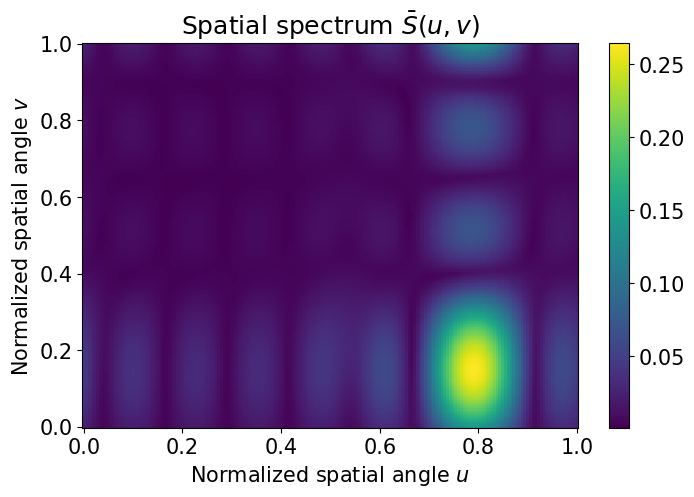

In [34]:
# Write your code here
# The following image is an example

### 📍 Mapping Spatial Frequencies to Physical Angles

Although the normalized spatial frequencies $(u,v)$ are related to the physical angles of arrival—namely, azimuth $\phi$ and elevation $\theta$—they are not identical.

The spatial frequencies represent projections of the incident wave vector onto the antenna array axes. Their relationship with the physical angles depends on the used coordinate system and the orientation of the antenna array.

In general, this relationship can be expressed as

$$
u = u(\phi,\theta), \qquad
v = v(\phi,\theta).
$$

---
### 📍 Special case
Assuming that the antenna array is placed in $(yz)$-plane with norm $x$, the normalized spatial frequencies are related to the azimuth and elevation angles by

$$
u(\phi,\theta)
=
d_h\cos(\theta)\sin(\phi),
\qquad
v(\phi,\theta)
=
d_v\sin(\theta).
$$

Here:

- $\phi$ denotes the azimuth angle in the horizontal plane,
- $\theta$ denotes the elevation angle measured from the horizontal plane.
- $d_h$ denotes horizontal antenna spacing measured in wavelenghts 
- $d_v$ denotes vertical antenna spacing measured in wavelenghts

These expressions are valid only for the specified array orientation and coordinate system depicted bellow

<img src="assets/spatial_scheme.jpg" width="500">,

where $\mathbf{r}=(r_x, r_y, r_z)$ is the direction vector, which we need to redifine as $\mathbf{r}(\phi,\theta)$.

Different orientations or reference frames lead to different mappings between $(u,v)$ and $(\phi,\theta)$.

Using the above relations, the spatial spectrum $\bar{S}(u,v)$ can be transformed into the angular domain and expressed as

$$
\bar{S}(\phi,\theta)
=
\bar{S}\big(u(\phi,\theta),\, v(\phi,\theta)\big).
$$

This representation allows the spatial spectrum to be interpreted directly in terms of physical propagation directions.

---

### 🔴 Optional Tasks

1. **Angular-Domain Visualization**

   Transform the averaged spatial spectrum $ \bar{S}(u,v) $ into the angular domain and plot
   $\bar{S}(\phi,\theta)$
   as a function of azimuth and elevation.

   Compare the obtained result with $\bar{S}(u,v)$.  
   Discuss the main differences in resolution, distortion, and physical interpretability.

2. **General Mapping Derivation**

   Derive the general expressions for $ u(\phi,\theta) $ and $ v(\phi,\theta) $ for an arbitrary antenna placement.


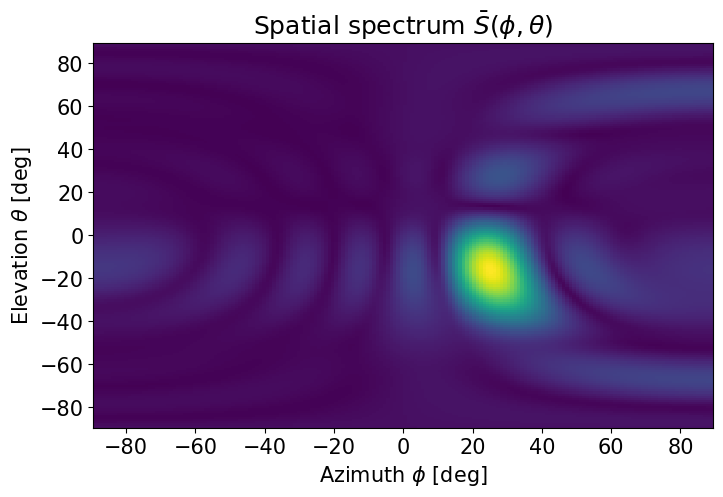

In [ ]:
# Write your code here
# The following image is an example

## 📘Beam-Domain Channel Approximation

Spatial spectrum analysis indicates that MIMO channel matrices are often sparse in the angular domain, meaning that only a limited number of dominant propagation paths contribute significantly to the received signal.

This sparsity property can be exploited to construct low-dimensional approximations of the channel in the beam (angular) domain.

In this section, we apply the discrete Fourier transform (DFT) to project the channel into the beam domain.

---

### 📍Discrete Fourier Transform Matrix

The DFT matrix
$
\mathbf{F} \in \mathbb{C}^{N \times N}
$
is defined as

$$
[\mathbf{F}]_{n,k}
=
\frac{1}{\sqrt{N}}
\exp\left(-j\frac{2\pi}{N}nk\right),
\qquad
n,k \in \{0,1,\ldots,N-1\}.
$$

This matrix represents an orthonormal basis of fixed spatial beams.

---

### 📍 Beam-domain approximation algorithm

For each fixed subcarrier $k$, user antenna $m$, and time instant $t$, the channel vector
$\mathbf{h} \in \mathbb{C}^{N}$

can be projected into the beam domain as

$$\mathbf{z}=\mathbf{F}\mathbf{h},$$

where $\mathbf{z} \in \mathbb{C}^{N}$ is the beam-domain channel representation.

To obtain a low-rank approximation, we retain only the $B$ beam components with the largest magnitudes in $ |\mathbf{z}| $ and set all remaining components to zero.

This operation can be expressed as

$$
\hat{\mathbf{z}}
=
\mathbf{M}\mathbf{z},
$$

where
$\mathbf{M} \in \mathbb{C}^{N \times N}$
is a diagonal selection matrix whose diagonal entries are equal to 1 for the selected beams and 0 otherwise.

> ⚠️ **Implementation Note:**  
> You should not explicitly construct the matrix $\mathbf{M}$, since this leads to unnecessary computational overhead. Instead, apply beam selection using index-based masking.

The approximated channel in the antenna domain is obtained via the inverse DFT:

$$
\hat{\mathbf{h}}
=
\mathbf{F}^H
\hat{\mathbf{z}},
$$

where $\mathbf{F}^H$ denotes the Hermitian transpose of $\mathbf{F}$.

In practice, this operation is efficiently implemented using the inverse FFT.

> For this task, you are allowed to use `np.fft.fft` and `np.fft.ifft` instead of explicitly forming $\mathbf{F}$.

---

### 🔴 Assignment Tasks

1. Implement a beam-domain approximation filter using FFT and inverse FFT operations.

2. Apply the beam approximation with $B \in \{1,\,4,\,8\}$
   For each value of $B$:
   - construct the approximated channel,
   - compute the corresponding SVD-based precoder,
   - plot the BER–SNR performance curves.

3. For each value of $B$, compute and visualize the averaged spatial spectrum
   $\bar{S}(u,v)$
   corresponding to the approximated channel.

4. Analyze and explain the observed results.


In [46]:
def fft_approximate(H, N_beams):
    '''
    :param H: (np.ndarray) the channel array
    :param N_beams: (int) number of beams to be kept
    :return: (np.ndarray) approximated with N_beams channel array
    '''
    
    raise NotImplementedError('FFT approximation is not implemented yet.')

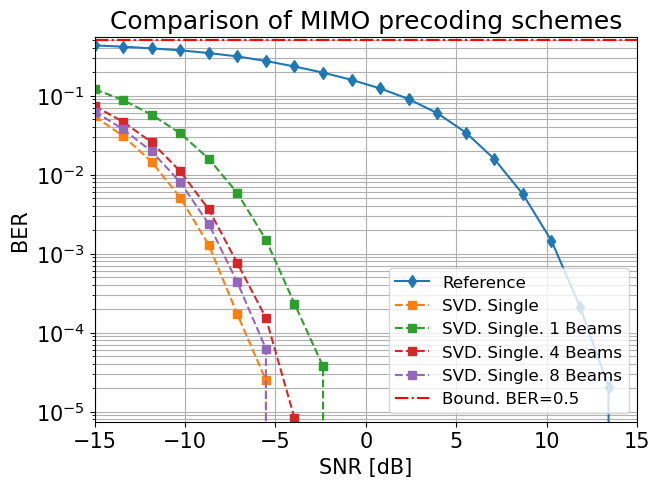

In [48]:
# Write your code here
# The following image is an example